In [1]:
# Copyright (c) 2023, ETH Zurich, Alexandre Didier, Andrea Zanelli, Kim P. Wabersich, Prof. Dr. Melanie N. Zeilinger, 
# Institute for Dynamic Systems and Control, D-MAVT

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from stab_filter.utils import *
from stab_filter.params import CarParams
from stab_filter.controller import Lqr, StabilityFilter
np.random.seed(123)

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


### Get Experiment Data

In [4]:
p = CarParams()

### Design controllers

In [5]:
P_u = pt.box2poly(p['u_box'])
p['Au'] = P_u.A
p['bu'] = P_u.b

# discretize dynamics
dyn_d_low = lambda x,u : discretize(dyn_low, x, u, p)
dyn_d = lambda x,u : discretize(dyn, x, u, p)

# compute steady state
x_sp, u_sp =  compute_steady_state(dyn_d_low, 0, p['vdes'], p)
print(f"Target vx={x_sp[3]}\nTarget vy={x_sp[4]}\nTarget psid={x_sp[5]}\nTarget delta={x_sp[6]}\nCorresponding torque={u_sp[1]}")

# compute linearization
a_low_full,b_low_full = linearize_dyn(dyn_d_low, x_sp, u_sp)
a_low = a_low_full[1:,1:]
b_low = b_low_full[1:]
a_full,b_full = linearize_dyn(dyn_d, x_sp, u_sp)
a = a_full[1:,1:]
b = b_full[1:]

# compute approximate additive disturbance caused by nonlinearity
wbox_full, P_w = get_disturbance_set(p, x_sp, u_sp, dyn_d_low, a_low, b_low)

# linear simulation
dyn_d_low_lin = lambda x,u : x_sp + a_low_full @ (x-x_sp) + b_low_full @ (u-u_sp)  + np.array([np.random.uniform(wbox_full[i,0], wbox_full[i,1],1) for i in range(wbox_full.shape[0])]).ravel()
dyn_d_lin = lambda x,u : x_sp + a_full @ (x-x_sp) + b_full @ (u-u_sp)  + np.array([np.random.uniform(wbox_full[i,0], wbox_full[i,1],1) for i in range(wbox_full.shape[0])]).ravel()

# generate 'human' controllers
lqr = Lqr(a,b,dict(q=p['q_driver'],r=p['r_driver']),x_sp=x_sp[1:],u_sp=u_sp)
lqr.k_ = 0 * lqr.k_
lqr.k_[0,0] = -0.1
lqr.k_[0,1] = -0.05
lqr.k_[0,5] = 0.00
lqr.k_[1,2] = -1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Target vx=1.1
Target vy=0.0
Target psid=0.0
Target delta=0.0
Corresponding torque=0.20960501102412848


In [6]:
# generate stability filter
sbf = StabilityFilter(a_low,b_low,x_sp[1:],u_sp, P_w.A, P_w.b, p)
x0 = np.array([0 ,0 ,p['psi0'] , 0.5 * p['vdes'] * np.cos(p['psi0']) , 0.5 * -p['vdes']*np.sin(p['psi0']) , p['psi0'] ,0]) # <-- Mildly sliding initial condition

Compute constraint tightening prediction step 1
Compute constraint tightening prediction step 2
Compute constraint tightening prediction step 3
Compute constraint tightening prediction step 4
Compute constraint tightening prediction step 5
Compute constraint tightening prediction step 6
Compute constraint tightening prediction step 7
Compute constraint tightening prediction step 8
Compute constraint tightening prediction step 9
Compute constraint tightening prediction step 10
Compute constraint tightening prediction step 11
Compute constraint tightening prediction step 12
Compute constraint tightening prediction step 13
Compute constraint tightening prediction step 14
Compute constraint tightening prediction step 15
Compute constraint tightening prediction step 16
Compute constraint tightening prediction step 17
Compute constraint tightening prediction step 18
Compute constraint tightening prediction step 19
Compute constraint tightening prediction step 20
Compute constraint tightening

### Execute Simulations

In [7]:
# lqr
x_sim_lin_hum, u_sim_lin_hum, v_sim_lin_hum, udev_sim_lin_hum, _ = sim(lambda x,u:dyn_d_low_lin(x,u), lambda x:lqr.evaluate(x[1:]), x0, p)
x_sim_nonlin_hum, u_sim_nonlin_hum, v_sim_nonlin_hum, udev_sim_nonlin_hum, _ = sim(lambda x,u:dyn_d_low(x,u), lambda x:lqr.evaluate(x[1:]), x0, p)

# sbf, rho 1
sbf.rho_ = p['rho1']
#sbf.opti_.set_value(sbf.rho_, p['rho1'])
sbf.u_last_ = 1e1 * np.ones((sbf.nu_, p['n_mpc']))
sbf.x1pred_.value = 1e1 * np.ones((sbf.nx_,))
# sbf.opti_.set_value(sbf.x1pred_, 1e1 * np.ones((sbf.nx_,1)))
x_sim_lin_sbf1, u_sim_lin_sbf1, v_sim_lin_sbf1, udev_sim_lin_sbf1, w_sim_lin_sbf1 = sim(lambda x,u:dyn_d_low_lin(x,u), lambda x:sbf.evaluate(lqr.evaluate(x[1:])[0], x[1:]), x0, p)
sbf.u_last_ = 1e1 * np.ones((sbf.nu_, p['n_mpc']))
sbf.x1pred_.value = 1e1 * np.ones((sbf.nx_,))
# sbf.opti_.set_value(sbf.x1pred_, 1e1 * np.ones((sbf.nx_,1)))
x_sim_nonlin_sbf1, u_sim_nonlin_sbf1, v_sim_nonlin_sbf1, udev_sim_nonlin_sbf1, w_sim_nonlin_sbf1 = sim(lambda x,u:dyn_d_low(x,u), lambda x:sbf.evaluate(lqr.evaluate(x[1:])[0], x[1:]), x0, p)

# sbf, rho 2
sbf.rho_ = p['rho2']
# sbf.opti_.set_value(sbf.rho_, p['rho2'])
sbf.u_last_ = 1e1 * np.ones((sbf.nu_, p['n_mpc']))
sbf.x1pred_.value = 1e1 * np.ones((sbf.nx_,))
#sbf.opti_.set_value(sbf.x1pred_, 1e1 * np.ones((sbf.nx_,1)))
x_sim_lin_sbf2, u_sim_lin_sbf2, v_sim_lin_sbf2, udev_sim_lin_sbf2, w_sim_lin_sbf2 = sim(lambda x,u:dyn_d_low_lin(x,u), lambda x:sbf.evaluate(lqr.evaluate(x[1:])[0], x[1:]), x0, p)
sbf.u_last_ = 1e1 * np.ones((sbf.nu_, p['n_mpc']))
sbf.x1pred_.value = 1e1 * np.ones((sbf.nx_,))
# sbf.opti_.set_value(sbf.x1pred_, 1e1 * np.ones((sbf.nx_,1)))
x_sim_nonlin_sbf2, u_sim_nonlin_sbf2, v_sim_nonlin_sbf2, udev_sim_nonlin_sbf2, w_sim_nonlin_sbf2 = sim(lambda x,u:dyn_d_low(x,u), lambda x:sbf.evaluate(lqr.evaluate(x[1:])[0], x[1:]), x0, p)

# sbf, rho 3
# sbf.opti_.set_value(sbf.rho_, p['rho3'])
sbf.rho_ = p['rho3']
sbf.u_last_ = 1e1 * np.ones((sbf.nu_, p['n_mpc']))
sbf.x1pred_.value = 1e1 * np.ones((sbf.nx_,))
# sbf.opti_.set_value(sbf.x1pred_, 1e10 * np.ones((sbf.nx_,1)))
x_sim_lin_sbf3, u_sim_lin_sbf3, v_sim_lin_sbf3, udev_sim_lin_sbf3, w_sim_lin_sbf3 = sim(lambda x,u:dyn_d_low_lin(x,u), lambda x:sbf.evaluate(lqr.evaluate(x[1:])[0], x[1:]), x0, p)
sbf.u_last_ = 1e1 * np.ones((sbf.nu_, p['n_mpc']))
sbf.x1pred_.value = 1e1 * np.ones((sbf.nx_,))
# sbf.opti_.set_value(sbf.x1pred_, 1e10 * np.ones((sbf.nx_,1)))
x_sim_nonlin_sbf3, u_sim_nonlin_sbf3, v_sim_nonlin_sbf3, udev_sim_nonlin_sbf3, w_sim_nonlin_sbf3 = sim(lambda x,u:dyn_d_low(x,u), lambda x:sbf.evaluate(lqr.evaluate(x[1:])[0], x[1:]), x0, p)

# set first value of lyapunov function to zero
v_sim_lin_hum[0,0]=0
v_sim_nonlin_hum[0,0] = 0
v_sim_lin_sbf1[0,0]=0
v_sim_nonlin_sbf1[0,0]=0
v_sim_lin_sbf2[0,0]=0
v_sim_nonlin_sbf2[0,0]=0
v_sim_nonlin_sbf2[0,0]=0
v_sim_lin_sbf3[0,0]=0
v_sim_nonlin_sbf3[0,0]=0
v_sim_lin_sbf3[0,0]=0

Steering=-0.01 -> -0.01 | Torque=0.77 -> 0.77 | V(x,w) = 6797792.35
Steering=-0.01 -> -0.01 | Torque=0.73 -> 0.73 | V(x,w) = 79.90
Steering=-0.01 -> -0.01 | Torque=0.69 -> 0.69 | V(x,w) = 61.97
Steering=-0.01 -> -0.33 | Torque=0.64 -> 0.70 | V(x,w) = 60.08
Steering=-0.01 -> -0.20 | Torque=0.60 -> 0.64 | V(x,w) = 58.84
Steering=-0.01 -> -0.04 | Torque=0.57 -> 0.57 | V(x,w) = 57.72
Steering=-0.01 -> -0.15 | Torque=0.54 -> 0.57 | V(x,w) = 56.65
Steering=-0.01 -> -0.25 | Torque=0.51 -> 0.56 | V(x,w) = 54.96
Steering=-0.01 -> -0.09 | Torque=0.48 -> 0.50 | V(x,w) = 53.91
Steering=-0.01 -> -0.17 | Torque=0.46 -> 0.50 | V(x,w) = 52.78
Steering=-0.01 -> -0.01 | Torque=0.43 -> 0.43 | V(x,w) = 51.13
Steering=-0.01 -> -0.01 | Torque=0.41 -> 0.41 | V(x,w) = 49.78
Steering=-0.01 -> -0.01 | Torque=0.39 -> 0.39 | V(x,w) = 47.57
Steering=-0.01 -> -0.01 | Torque=0.38 -> 0.38 | V(x,w) = 45.44
Steering=-0.01 -> -0.01 | Torque=0.36 -> 0.36 | V(x,w) = 42.81
Steering=-0.01 -> -0.01 | Torque=0.35 -> 0.35 | V(

### Generate plots

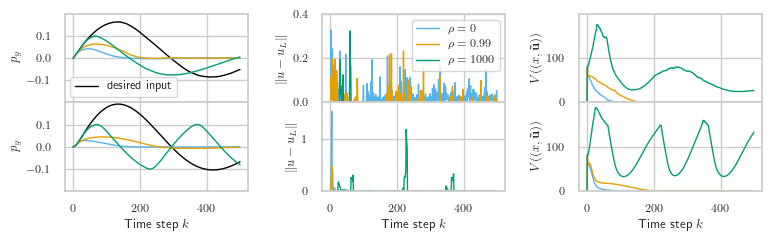

In [8]:
# general plotting parameters
plot_param = {
    "linewidth": 1.0,
    "linewidth_thin": 1.0,
    "fig_size": (2, 3),
    "color_1": (0,0,0),
    "color_2": (86/255,180/255,233/255),
    "color_3": (230/255,159/255,0/255),
    "color_4": (0/255,158/255,115/255),
    "label_1" : 'desired input',
    "label_2" : '$\\rho = 0$',
    "label_3" : '$\\rho = 0.99$',
    "label_4" : '$\\rho = 1000$',
    "linestyle_1": "-",
    "linestyle_2": "-",
    "linestyle_3": "-",
    "linestyle_4": "-"
}
sns.set(font_scale=0.75, rc={"text.usetex": True, "font.family": "sans-serif"})
sns.set_style("whitegrid")
sns.set_color_codes("deep")
nsim = len(x_sim_lin_hum[0,:])

fig, ax = plt.subplots(2,3, figsize=(9,2.3))

# Y-Offset linear + additive disturbance
time = np.array([i for i in range(nsim)])
y_off_1 = x_sim_lin_hum[1,:]
y_off_2 = x_sim_lin_sbf1[1,:]
y_off_3 = x_sim_lin_sbf2[1,:]
y_off_4 = x_sim_lin_sbf3[1,:]
#fig, ax = plt.subplots(figsize=plot_param["fig_size"])
sns.lineplot(
    ax=ax[0][0],
    x=time,
    y=y_off_1,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_1"],
    color=plot_param["color_1"],
    label=plot_param["label_1"],
)
sns.lineplot(
    ax=ax[0][0],
    x=time,
    y=y_off_2,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_2"],
    color=plot_param["color_2"],
    #label=plot_param["label_2"],
)
sns.lineplot(
    ax=ax[0][0],
    x=time,
    y=y_off_3,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_3"],
    color=plot_param["color_3"],
    #label=plot_param["label_3"],
)
sns.lineplot(
    ax=ax[0][0],
    x=time,
    y=y_off_4,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_4"],
    color=plot_param["color_4"],
    ##label=plot_param["label_4"],
)
ax[0][0].tick_params(axis='x', bottom=False, labelbottom=False)
ax[0][0].set_ylabel("$p_y$")
ax[0][0].set_ylim(-0.199, 0.199)
#plt.savefig(os.getcwd() + "/y_off_lin_dist.pdf", bbox_inches="tight", pad_inches=0)

# Y-Offset nonlinear
y_off_1 = x_sim_nonlin_hum[1,:]
y_off_2 = x_sim_nonlin_sbf1[1,:]
y_off_3 = x_sim_nonlin_sbf2[1,:]
y_off_4 = x_sim_nonlin_sbf3[1,:]
#fig, ax = plt.subplots(figsize=plot_param["fig_size"])
sns.lineplot(
    ax=ax[1][0],
    x=time,
    y=y_off_1,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_1"],
    color=plot_param["color_1"],
    #label=plot_param["label_1"],
)
sns.lineplot(
    ax=ax[1][0],
    x=time,
    y=y_off_2,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_2"],
    color=plot_param["color_2"],
    #label=plot_param["label_2"],
)
sns.lineplot(
    ax=ax[1][0],
    x=time,
    y=y_off_3,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_3"],
    color=plot_param["color_3"],
    #label=plot_param["label_3"],
)
sns.lineplot(
    ax=ax[1][0],
    x=time,
    y=y_off_4,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_4"],
    color=plot_param["color_4"],
    #label=plot_param["label_4"],
)
ax[1][0].set_xlabel("Time step $k$")
ax[1][0].set_ylabel("$p_y$")
ax[1][0].set_ylim(-0.199, 0.199)

#plt.savefig(os.getcwd() + "/y_off_nonlin_dist.pdf", bbox_inches="tight", pad_inches=0)

# Stability cost linear simulation
v_1 = v_sim_lin_sbf1[0,:]
v_2 = v_sim_lin_sbf2[0,:]
v_3 = v_sim_lin_sbf3[0,:]
#fig, ax = plt.subplots(figsize=plot_param["fig_size"])
sns.lineplot(
    ax=ax[0][2],
    x=time,
    y=v_1,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_2"],
    color=plot_param["color_2"],
    #label=plot_param["label_2"],
)
sns.lineplot(
    ax=ax[0][2],
    x=time,
    y=v_2,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_3"],
    color=plot_param["color_3"],
    #label=plot_param["label_3"],
)
sns.lineplot(
    ax=ax[0][2],
    x=time,
    y=v_3,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_4"],
    color=plot_param["color_4"],
    #label=plot_param["label_4"],
)
ax[0][2].tick_params(axis='x', bottom=False, labelbottom=False)
ax[0][2].set_ylabel(r"$V((x,\mathbf{\tilde{u}}))$")
ax[0][2].set_ylim(0, 199)

#plt.savefig(os.getcwd() + "/v_lin_dist.pdf", bbox_inches="tight", pad_inches=0)

# Stability cost nonlinear simulation
v_1 = v_sim_nonlin_sbf1[0,:]
v_2 = v_sim_nonlin_sbf2[0,:]
v_3 = v_sim_nonlin_sbf3[0,:]
#fig, ax = plt.subplots(figsize=plot_param["fig_size"])
sns.lineplot(
    ax=ax[1][2],
    x=time,
    y=v_1,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_2"],
    color=plot_param["color_2"],
    #label=plot_param["label_2"],
)
sns.lineplot(
    ax=ax[1][2],
    x=time,
    y=v_2,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_3"],
    color=plot_param["color_3"],
    #label=plot_param["label_3"],
)
sns.lineplot(
    ax=ax[1][2],
    x=time,
    y=v_3,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_4"],
    color=plot_param["color_4"],
    #label=plot_param["label_4"],
)
ax[1][2].set_xlabel("Time step $k$")
ax[1][2].set_ylabel(r"$V((x,\mathbf{\tilde{u}}))$")
ax[1][2].set_ylim(0, 199)
#plt.savefig(os.getcwd() + "/v_nonlin_dist.pdf", bbox_inches="tight", pad_inches=0)


# Input deviation linear simulation
v_1 = udev_sim_lin_sbf1[0,:]
v_2 = udev_sim_lin_sbf2[0,:]
v_3 = udev_sim_lin_sbf3[0,:]
#fig, ax = plt.subplots(figsize=plot_param["fig_size"])
sns.lineplot(
    ax=ax[0][1],
    x=time,
    y=v_1,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_2"],
    color=plot_param["color_2"],
    label=plot_param["label_2"],
)
sns.lineplot(
    ax=ax[0][1],
    x=time,
    y=v_2,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_3"],
    color=plot_param["color_3"],
    label=plot_param["label_3"],
)
sns.lineplot(
    ax=ax[0][1],
    x=time,
    y=v_3,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_4"],
    color=plot_param["color_4"],
    label=plot_param["label_4"],
)
ax[0][1].tick_params(axis='x', bottom=False, labelbottom=False)
ax[0][1].set_ylabel("$\|u - u_{L}\|$")
ax[0][1].set_ylim(0, 0.4)
#plt.savefig(os.getcwd() + "/udev_lin_dist.pdf", bbox_inches="tight", pad_inches=0)

# Input deviation nonlinear simulation
v_1 = udev_sim_nonlin_sbf1[0,:]
v_2 = udev_sim_nonlin_sbf2[0,:]
v_3 = udev_sim_nonlin_sbf3[0,:]
#fig, ax = plt.subplots(figsize=plot_param["fig_size"])
sns.lineplot(
    ax=ax[1][1],
    x=time,
    y=v_1,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_2"],
    color=plot_param["color_2"],
    #label=plot_param["label_2"],
)
sns.lineplot(
    ax=ax[1][1],
    x=time,
    y=v_2,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_3"],
    color=plot_param["color_3"],
    #label=plot_param["label_3"],
)
sns.lineplot(
    ax=ax[1][1],
    x=time,
    y=v_3,
    linewidth=plot_param["linewidth_thin"],
    linestyle=plot_param["linestyle_4"],
    color=plot_param["color_4"],
    #label=plot_param["label_4"],
)
ax[1][1].set_xlabel("Time step $k$")
ax[1][1].set_ylabel("$\|u - u_L\|$")
ax[1][1].set_ylim(0, 1.7)
#plt.legend(loc="upper right")
plt.subplots_adjust(hspace=0, wspace=0.4)
# Save plot in plots folder
plt.savefig("../plots/vehicle_control.pdf", bbox_inches="tight", pad_inches=0)
